# Imports

In [1]:
import matplotlib.pyplot as plt
import spectral

from pathlib import Path
import numpy as np
import dask.array as da
from scipy.signal import savgol_filter
from spectral import open_image, remove_continuum, kmeans

# Get project

In [2]:
from hyperspec.from_napari_sediment.get_roi_and_mask import load_project_params

path_export_folder = Path(
    r"\\hlabstorage.dmz.marum.de\scratch\AEGIS\Cambodia\Cambodia VNIR\qd_CAM2506_60-90cm_2025-08-27_08-45-01\napari"
)
params = load_project_params(path_export_folder)

# Get data

In [129]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_im_main_roi
from hyperspec.from_napari_sediment.get_roi_and_mask import get_mask_main

# passing mainroi_index=None gives the entire dataset
imcube = get_im_main_roi(path_export_folder, mainroi_index=0)
imcube = da.moveaxis(imcube, 0, -1)
mask = get_mask_main(path_export_folder)

img = open_image(params.file_path)
bands = np.array(img.bands.centers)
metadata = img.metadata
rgb_channels = np.array(metadata['default bands']).astype(int)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


`imcube` contains the entire dataset of the main roi. This accesses the calibrated data but it is important to use the `get_im_main_roi` for this. `img` is not using the calibrated data but provides access to the metadata 

In [4]:
print(type(imcube))
imcube

<class 'dask.array.core.Array'>


dask.array<transpose, shape=(9261, 548, 952), dtype=float32, chunksize=(500, 317, 1), chunktype=numpy.ndarray>

`img` is a connection to the raw file from the `spectral` library

In [5]:
print(type(img))
img

<class 'spectral.io.bilfile.BilFile'>


	Data Source:   '//hlabstorage.dmz.marum.de/scratch/AEGIS/Cambodia/Cambodia VNIR/qd_CAM2506_60-90cm_2025-08-27_08-45-01/capture/qd_CAM2506_60-90cm_2025-08-27_08-45-01.raw'
	# Rows:          10258
	# Samples:        2184
	# Bands:           952
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16

In [6]:
print(type(metadata))
metadata.keys()

<class 'dict'>


dict_keys(['description', 'file type', 'sensor type', 'acquisition date', 'start time', 'stop time', 'samples', 'bands', 'lines', 'errors', 'interleave', 'data type', 'header offset', 'byte order', 'x start', 'y start', 'default bands', 'himg', 'vimg', 'hroi', 'vroi', 'fps', 'fps_qpf', 'tint', 'binning', 'binningaverage', 'trigger mode', 'trigger sync', 'fodis', 'sensorid', 'acquisitionwindow left', 'acquisitionwindow top', 'calibration pack', 'vnir temperature', 'scb temperature channel1', 'scb temperature channel2', 'scb temperature channel3', 'scb temperature channel4', 'temperature', 'wavelength', 'fwhm'])

# Spectral analysis on reduced data

mnf and PPI can be performed with `napari-sediment` as well but we lack some of the flexibility that we would like to have. Since it is based on the `spectral` library, we can make those calls here explicitly.

## MNF

measurement roi must contain some values ... sometimes napari does not export those values ... in that case open the console and past the following lines in:

In [7]:
params.rois[0]

[[16.0, 896.0, 9277.0, 896.0, 9277.0, 916.0, 16.0, 916.0]]

In [8]:
# meas_layer = viewer.layers[[l.name for l in viewer.layers].index('rois_0')]
# meas_layer.extent.data

In [9]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_data_red_roi, get_data_red_roi_from_extent

get_red_roi_manually = True

# perform mnf on masked subsection
print('obtaining roi')

if get_red_roi_manually:
    # row_start, row_end, col_start, col_end
    width_roi = 20
    row_start = 0
    row_end = imcube.shape[0]
    col_start = round(imcube.shape[1] / 2 - width_roi / 2)
    col_end = col_start + width_roi
    row_bounds_relative_to_main = [row_start, row_end, col_start, col_end]
    roi, mask_valid_roi = get_data_red_roi_from_extent(imcube, params, *row_bounds_relative_to_main, True)
    roi = np.asarray(roi)
else:
    roi, mask_valid_roi = get_data_red_roi(imcube, params, True)
    roi = np.asarray(roi)

print('calcing stats ...')
signal = spectral.calc_stats(roi, mask_valid_roi[:, :, 0])
print('calcing noise ...')
noise = spectral.noise_from_diffs(roi)
print('calcing nmf ...')
mnfr = spectral.mnf(signal, noise)

# De-noise the data by eliminating NAPC components where SNR < 10.
# The de-noised data will be in the original coordinate space (at
# full dimensionality).
print('denoising ...')
denoised_mnf = mnfr.denoise(roi, snr=10)

obtaining roi
obtaining roi_height=9261 x roi_width=20 x n_channels=952 datapoints
done obtaining data
calcing stats ...
calcing noise ...
calcing nmf ...
denoising ...


In [10]:
signal.cov.shape

(952, 952)

plot some of the eigenvectors (in columns according to documentation)

creating plot ...


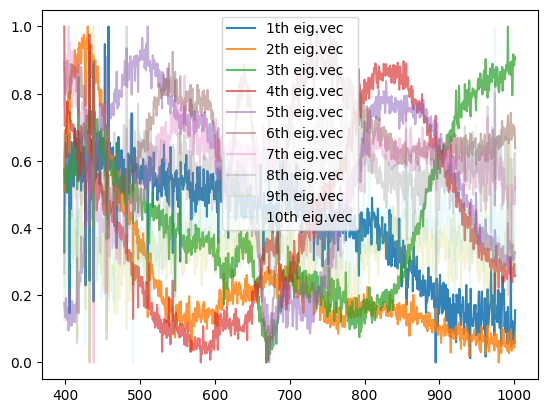

In [11]:
print('creating plot ...')
n_vecs = 10
plt.figure()
lams = img.bands.centers
for i in range(n_vecs):
    v = mnfr.napc.eigenvectors[:, i].copy()
    v -= v.min()
    v /= v.max()
    plt.plot(lams, v, alpha=1 - (i + 1) / (n_vecs + 1), label=f'{i + 1}th eig.vec')
plt.legend()

plot eigenvalues

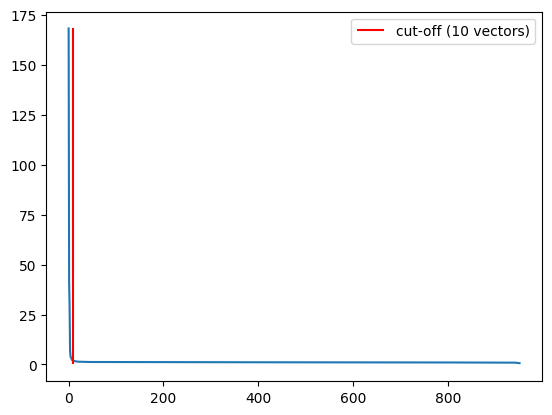

In [12]:
plt.plot(mnfr.napc.eigenvalues)
plt.vlines(n_vecs, 0, mnfr.napc.eigenvalues.max(), colors='red', label=f'cut-off ({n_vecs} vectors)')
plt.legend()

### understanding forward and backward reduction

In [13]:
mnfr.napc.eigenvalues

array([168.2152125 ,  41.32066179,  28.73602929,   6.86202028,
         3.91320083,   3.452624  ,   2.80606291,   2.27126178,
         2.12222933,   1.93931873,   1.83337895,   1.80031097,
         1.71754865,   1.66894178,   1.60075757,   1.55177281,
         1.48477868,   1.44182224,   1.40394567,   1.40163295,
         1.39338712,   1.36707423,   1.34679443,   1.33756266,
         1.3260484 ,   1.31780538,   1.31061643,   1.30779037,
         1.29784606,   1.29257625,   1.28755072,   1.28508246,
         1.27971686,   1.27745781,   1.27441274,   1.26849747,
         1.26637735,   1.26312038,   1.26214342,   1.2585261 ,
         1.2545027 ,   1.2522537 ,   1.25085826,   1.24807924,
         1.24479885,   1.24238118,   1.24184764,   1.23959944,
         1.23842389,   1.23740788,   1.23608761,   1.2343662 ,
         1.23348263,   1.23255102,   1.23133065,   1.22974043,
         1.22849952,   1.22771001,   1.22711913,   1.22602535,
         1.22561628,   1.2230537 ,   1.22259406,   1.22

In [14]:
# T = A^T * Z where Z is the zero-meaned data and A is the solution of the generalized eigenvalue problem 

def get_denoised(some_data, mnf_result, N):
    V = mnf_result.napc.eigenvectors
    # nullify all compounds over N
    Vr = np.array(V)
    Vr[:, N:] = 0.
    D = mnf_result.noise.sqrt_cov.dot(Vr) @ (V.T) @ (mnf_result.noise.sqrt_inv_cov)

    return D @ some_data


V = mnfr.napc.eigenvectors
# nullify all compounds over N
Vr = np.array(V)
Vr[:, n_vecs:] = 0.
D = mnfr.noise.sqrt_cov @ Vr @ V.T @ mnfr.noise.sqrt_inv_cov


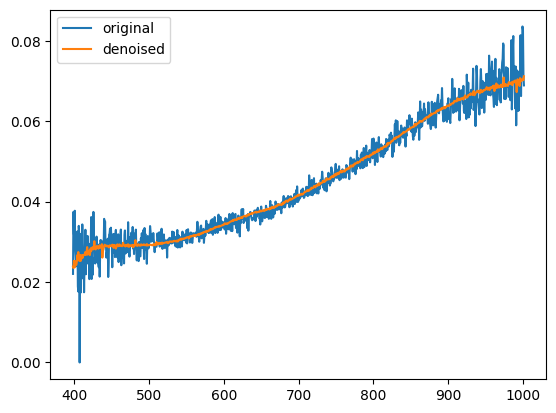

In [15]:
plt.plot(bands, roi[3, 3, :], label='original')
plt.plot(bands, (D @ roi[3, 3, :]), label='denoised')
plt.legend()

## Reduce dimensionality, retaining top 50 NAPC components.

In [16]:
reduced = mnfr.reduce(roi, num=n_vecs)

In [17]:
reduced.shape

(9261, 20, 10)

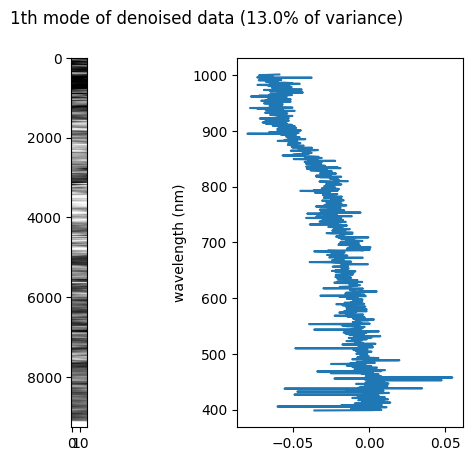

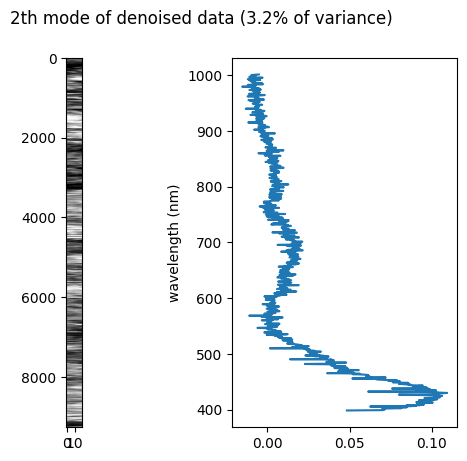

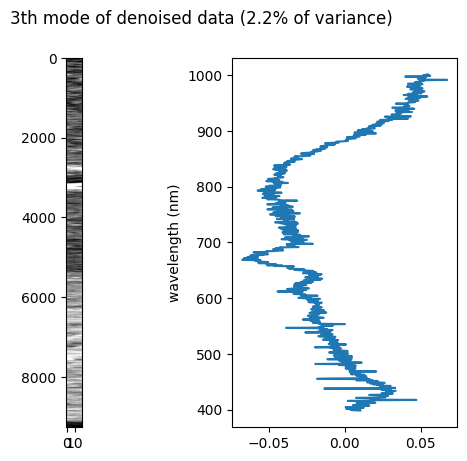

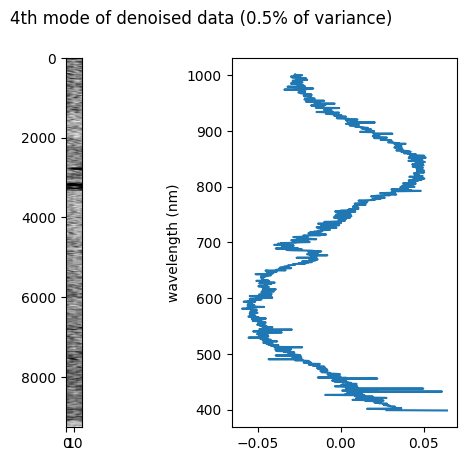

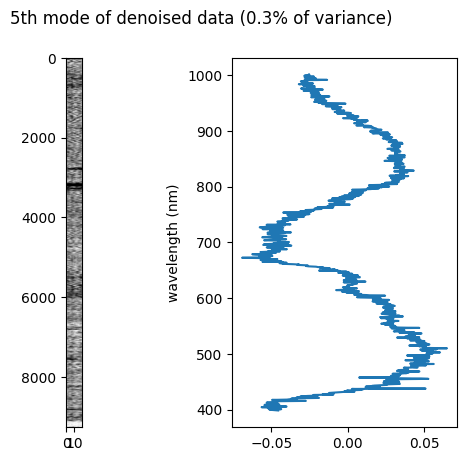

In [18]:
for i in range(min([n_vecs, 5])):
    fig, axs = plt.subplots(ncols=2)
    img = reduced[:, :, i]
    axs[0].imshow(img, vmin=np.quantile(img, .05), vmax=np.quantile(img, .95), aspect=1 / 20, cmap='grey')
    axs[1].plot(mnfr.napc.eigenvectors[:, i], lams)
    axs[1].set_ylabel('wavelength (nm)')
    fig.suptitle(
        f'{i + 1}th mode of denoised data ({mnfr.napc.eigenvalues[i] / mnfr.napc.eigenvalues.sum():.1%} of variance)')

## cluster

In [19]:
mask_valid_roi.shape, reduced.shape, mask_valid_roi[:, :, :reduced.shape[2]].shape

((9261, 20, 952), (9261, 20, 10), (9261, 20, 10))

### spectral implementation
(this is a lot slower than the sklearn one)

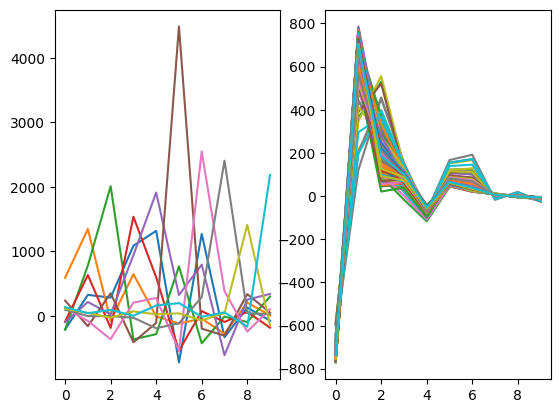

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import math

n_clusters_max = 10

on_reduced = True
normalize = True  # continuum contains information of total reflectance, which is useful information 

initials = mnfr.napc.eigenvectors[:, :n_clusters_max].copy()

n_test = 1000
random_indices = list(zip(
    np.random.choice(np.arange(denoised_mnf.shape[0]), size=n_test),
    np.random.choice(np.arange(denoised_mnf.shape[1]), size=n_test)
))

if normalize:
    initials = remove_continuum(initials.T, bands=bands).T
    # TODO: seems like remove continuum creates some artifacts
    initials[initials > 1] = 1
    initials[initials < -1] = -1

if on_reduced:
    initials = mnfr.reduce(initials.T, num=n_vecs).T

# initials = MinMaxScaler().fit_transform(initials)

fig, axs = plt.subplots(ncols=2)
for i in range(n_clusters_max):
    axs[0].plot(initials[:, i])

for i, j in random_indices:
    spec = denoised_mnf[i, j, :]
    if normalize:
        spec = remove_continuum(spec, bands=bands)
    if on_reduced:
        spec = mnfr.reduce(spec, num=n_vecs)
    axs[1].plot(spec)

In [21]:
reduced.shape

(9261, 20, 10)

In [22]:
from sklearn.metrics import silhouette_score

clusters_to_test = np.arange(2, n_clusters_max + 1)

# remove continuum and take 1 - cont_removed 
if normalize:
    normalized = remove_continuum(denoised_mnf, bands=bands)
else:
    normalized = denoised_mnf

# give it the bands but use the mask
if on_reduced:
    reduced = mnfr.reduce(normalized, num=n_vecs)
else:
    reduced = normalized

X_kmeans = reduced[mask_valid_roi[:, :, 0]]

In [23]:
X_kmeans.shape, (mask_valid_roi[:, :, 0].sum(), reduced.shape[2])

((139027, 10), (np.int64(139027), 10))

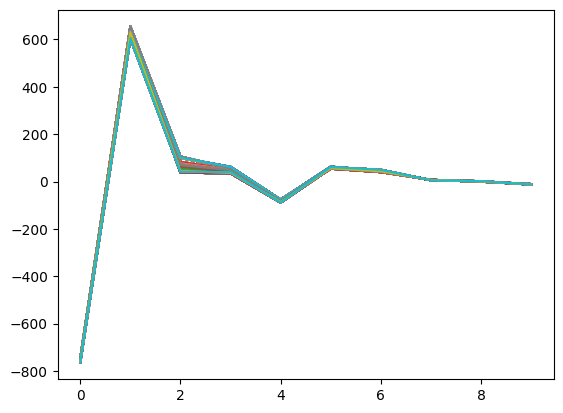

In [24]:
n_test = 1000

for i in np.random.choice(range(reduced.shape[1]), n_test):
    plt.plot(X_kmeans[i, :])


In [25]:
n_clusters = 6
# eigenvectors of mnf likely not good representatives of cluster centers
# cluster centers should not be a deconvolution, we can investigate this afterwards
kmeans_sk = KMeans(n_clusters=n_clusters, init=initials[:, :n_clusters].T)
# exclude holes from fit but not from predicting
kmeans_sk.fit(X_kmeans)
labels = kmeans_sk.predict(reduced.reshape(math.prod(reduced.shape[:2]), -1)).reshape(reduced.shape[:2])

In [26]:
print('starting silhoutte calculation')
res = {}
for n_clusters in clusters_to_test:
    # use sklearn instead
    kmeans_sk = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans_sk.fit_predict(X_kmeans)
    silhouette_avg = silhouette_score(X_kmeans, cluster_labels, sample_size=10_000)
    res[n_clusters] = (silhouette_avg, kmeans_sk)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

starting silhoutte calculation
For n_clusters = 2 The average silhouette_score is : 0.3395103591443514
For n_clusters = 3 The average silhouette_score is : 0.35610521042567606
For n_clusters = 4 The average silhouette_score is : 0.32931726409879036
For n_clusters = 5 The average silhouette_score is : 0.3182677539301845
For n_clusters = 6 The average silhouette_score is : 0.3117799937889602
For n_clusters = 7 The average silhouette_score is : 0.31298860436085435
For n_clusters = 8 The average silhouette_score is : 0.3010878571231734
For n_clusters = 9 The average silhouette_score is : 0.29246186337187086
For n_clusters = 10 The average silhouette_score is : 0.2924423467581937


In [27]:
kmeans_sk = res[3][1]
labels = kmeans_sk.predict(reduced.reshape(math.prod(reduced.shape[:2]), -1)).reshape(reduced.shape[:2])

In [28]:
labels.shape, mask_valid_roi.shape

((9261, 20), (9261, 20, 952))

In [63]:
# add new label for holes
# for ngist colormap it makes sense to set this label to the highest value since it appears as white
labels[~mask_valid_roi[:, :, 0]] = labels.max() + 1
u_labels = np.unique(labels)
n_labels = len(u_labels)

# use denoised (and normalized) to recalculate cluster centers
centers_kmeans = np.zeros((n_labels, denoised_mnf.shape[2]))

if normalize:
    for_centers = remove_continuum(denoised_mnf, bands=bands)
else:
    for_centers = denoised_mnf

for i, l in enumerate(u_labels):
    mask_label = labels == l
    centers_kmeans[i, :] = for_centers[mask_label, :].mean(axis=0)

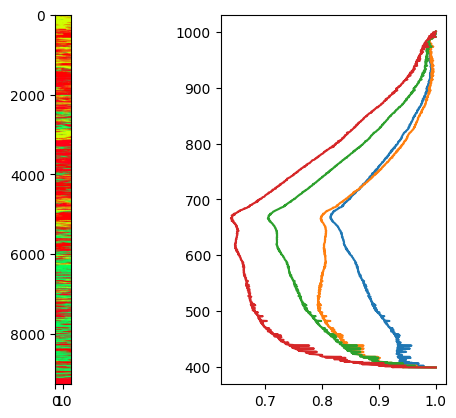

In [64]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(labels, aspect=1 / 20, cmap='hsv')
for i in range(centers_kmeans.shape[0]):
    axs[1].plot(centers_kmeans[i, :], bands)

### define wavelengths of troughs

Text(0.5, 0, 'Wavelength (nm)')

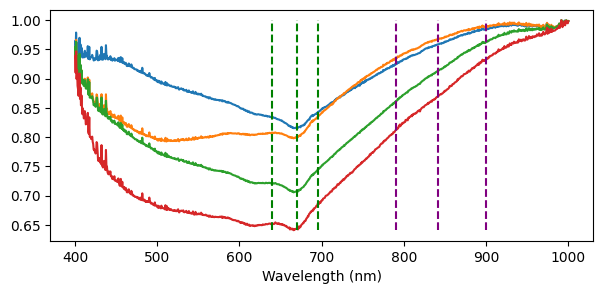

In [112]:
mask_wl = (bands > 400) & (bands < 1000)

fig, axs = plt.subplots(figsize=(7, 3))
for i in range(centers_kmeans.shape[0]):
    plt.plot(bands[mask_wl], centers_kmeans[i, mask_wl])
# plt.plot(bands, denoised_mnf.mean(axis=(0, 1)))
plt.vlines([640, 670, 695], centers_kmeans[:, mask_wl].min(), centers_kmeans[:, mask_wl].max(), linestyles='--', colors='green')
plt.vlines([790, 900, 842], centers_kmeans[:, mask_wl].min(), centers_kmeans[:, mask_wl].max(), linestyles='--', colors='purple')
plt.xlabel('Wavelength (nm)')

### extent kmeans annotations to entire image

In [31]:
imcube_for_pred = np.asarray(imcube, dtype=float)
if normalize:
    imcube_for_pred = remove_continuum(imcube_for_pred, bands=bands)
    if on_reduced:
        imcube_for_pred = mnfr.reduce(imcube_for_pred, num=n_vecs)
elif on_reduced:
    imcube_for_pred = mnfr.reduce(imcube_for_pred, num=n_vecs)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\algorithms\continuum.py:221: RuntimeWarning: invalid value encountered in divide
  out[i, j, :] /= continuum


In [32]:
imcube_for_pred[np.isnan(imcube_for_pred)] = 0

In [130]:
kmeans_sk = KMeans(n_clusters=5)
labels_full = kmeans_sk.fit_predict(imcube_for_pred.reshape(math.prod(imcube_for_pred.shape[:2]), -1)).reshape(imcube_for_pred.shape[:2])
labels_full[mask > 0] = labels_full.max() + 1

In [125]:
np.unique(labels_full)

array([0, 1, 2, 3, 4], dtype=int32)

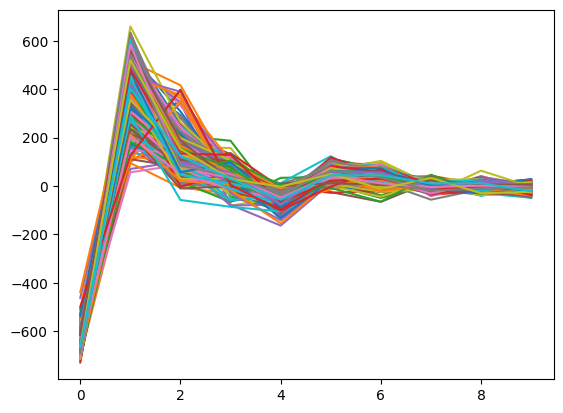

In [121]:
n_test = 1000
random_indices = list(zip(
    np.random.choice(np.arange(imcube_for_pred.shape[0]), size=n_test),
    np.random.choice(np.arange(imcube_for_pred.shape[1]), size=n_test)
))

for i, j in random_indices:
    spec = imcube_for_pred[i, j, :]
    plt.plot(spec)

In [122]:
from tqdm import tqdm

ncols, nrows = imcube.shape[:2]

I, J = np.meshgrid(range(ncols), range(nrows))
ij = zip(I.ravel(), J.ravel())

if not on_reduced:
    print('only works for not reduced, would need some other method otherwise')

labels_full = np.zeros((ncols, nrows))

label_invalid = labels.max()
for i, j in tqdm(ij, total=ncols * nrows):
    if mask[i, j]:
        labels_full[i, j] = label_invalid
    else:
        labels_full[i, j] = kmeans_sk.predict(imcube_for_pred[i, j, :].reshape(1, -1))[0]

  2%|▏         | 94013/5075028 [00:03<03:18, 25116.97it/s]


KeyboardInterrupt: 

In [117]:
np.unique(labels_full, return_counts=True)

(array([0, 1, 2], dtype=int32), array([   1314, 4572161,  501553]))

Text(0.5, 1.0, 'kmeans clusters')

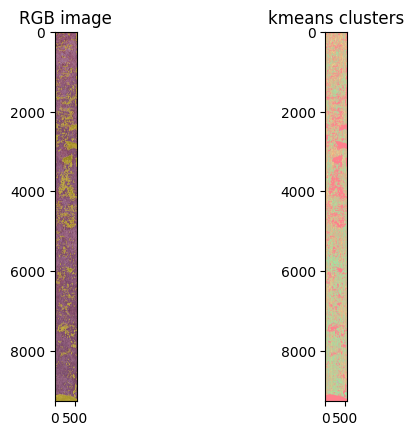

In [132]:
import matplotlib.pyplot as plt

rgb_img = imcube[:, :, rgb_channels]
thr = np.quantile(rgb_img, .95, axis=(0, 1))
thr = thr.max()
rgb_img[rgb_img > thr] = thr
rgb_img /= thr
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(rgb_img)
axs[0].imshow(mask, alpha=.5)
axs[0].set_title('RGB image')

# draw red rectangle
# from matplotlib import patches
# rect = patches.Rectangle(xy=(col_start, row_start),
#                          width=col_end-col_start,
#                          height=row_end-row_start,
#                          edgecolor='red')
# axs[0].add_patch(rect)

axs[1].imshow(labels_full, cmap='hsv', alpha=.5)
axs[1].set_title('kmeans clusters')

# corrected = np.array(imcube[10, 10, :])
# cont_removed = remove_continuum(corrected, bands=bands)
# axs[1].plot(corrected, bands)
# axs[1].plot(cont_removed, bands)
# axs[1].set_title('exemplary spectrum (with continuum removed)')


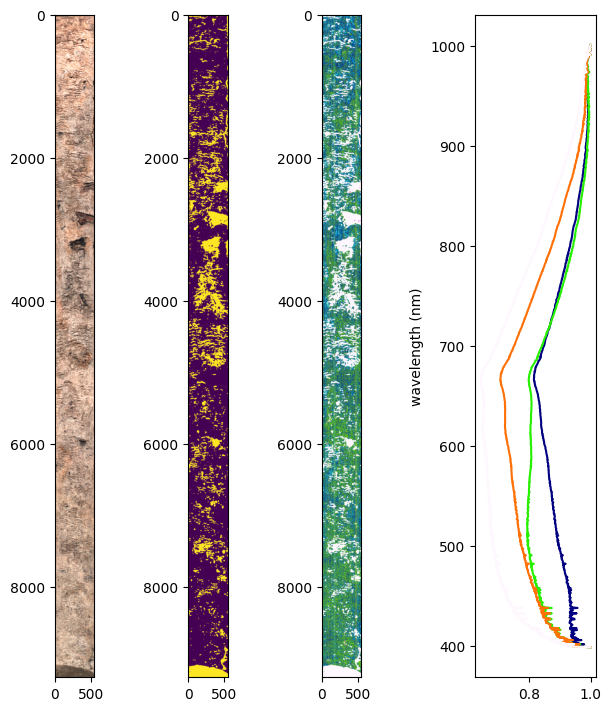

In [133]:
import matplotlib

fig, axs = plt.subplots(ncols=4, sharey=False, layout='constrained', figsize=(6, 7))
axs[0].imshow(rgb_img)
axs[1].imshow(mask)
axs[2].imshow(labels_full, cmap='gist_ncar')

cmap = matplotlib.colormaps['gist_ncar']
n_centers = centers_kmeans.shape[0]
for i in range(n_centers):
    axs[3].plot(centers_kmeans[i, :], bands, c=cmap(i / (n_centers - 1)))

# add bars for rgb channels
wl_rgb = bands[rgb_channels]
# axs[3].hlines(wl_rgb, 0, centers_kmeans.max, colors=['r', 'g', 'b'])

axs[3].set_ylabel('wavelength (nm)')
axs[3].set_title('')

fig.savefig('clusters.pdf')

In [38]:
np.save('cluster_centers.npy', centers_kmeans)

## pure pixel index

Running 5000 pixel purity iterations...interrupted
KeyboardInterrupt received. Returning pixel purity values after 3332 iterations.

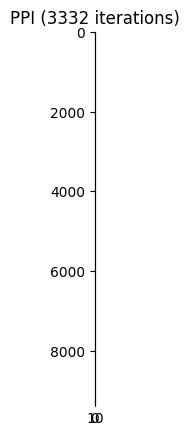

In [39]:
counts = spectral.algorithms.ppi(denoised_mnf, niters=5000, centered=False, display=1)

11


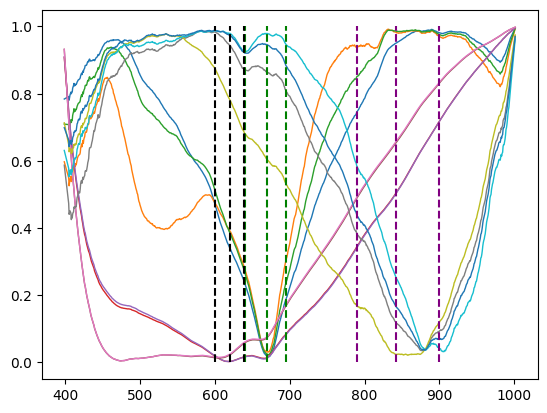

In [110]:
from scipy.signal import savgol_filter

thr_counts = 200
mask = counts > thr_counts
print(mask.sum())
endmembers = denoised_mnf[mask]

for i in range(endmembers.shape[0]):
    y = remove_continuum(endmembers[i, :], bands=bands)
    y -= y.min()
    y /= y.max()
    y = savgol_filter(y, window_length=21, polyorder=1)
    plt.plot(bands, y, linewidth=1)
plt.vlines([640, 670, 695], 0, 1, linestyles='--', colors='green')
plt.vlines([790, 900, 842], 0, 1, linestyles='--', colors='purple')
plt.vlines([620, 639, 600], 0, 1, linestyles='--', colors='black')

np.float64(0.20553532110367995)

# Deconvolution
## perform NMF on cluster centers

In [41]:
import numpy as np

centers_kmeans = np.load('cluster_centers.npy')

In [42]:
centers_kmeans

array([[1.        , 0.95192681, 0.95830906, ..., 0.99835116, 0.99983866,
        1.        ],
       [1.        , 0.94130816, 0.94524802, ..., 0.99859505, 0.99999946,
        1.        ],
       [1.        , 0.94174602, 0.94835191, ..., 0.9985325 , 0.99962047,
        1.        ],
       [1.        , 0.92359186, 0.93048721, ..., 0.99828208, 0.99932634,
        1.        ]], shape=(4, 952))

In [43]:
from sklearn.decomposition import NMF

model = NMF(max_iter=10000, init='nndsvd', n_components=4)

X = 1 - centers_kmeans.T
mask_NMF_too_low = X < .01
print(mask_NMF_too_low.sum(), mask_NMF_too_low.mean())
X[mask_NMF_too_low] = 0

# remove non-informative channels (channels that are all zero
# mask_non_informative_channel = (X == 0).all(axis=1)
mask_non_informative_channel = bands > 800  # crop off everything above 800 nm
# mask_non_informative_channel = np.zeros_like(bands, dtype=bool)


W = model.fit_transform(X[~mask_non_informative_channel, :])
H = model.components_

259 0.06801470588235294


In [44]:
W.shape, H.shape, model.reconstruction_err_

((641, 4), (4, 4), np.float64(0.001981588235001248))

In [45]:
bands[~mask_non_informative_channel]

array([398.43, 399.02, 399.6 , 400.19, 400.78, 401.37, 401.97, 402.56,
       403.15, 403.74, 404.33, 404.92, 405.51, 406.1 , 406.69, 407.29,
       407.88, 408.47, 409.06, 409.65, 410.25, 410.84, 411.43, 412.03,
       412.62, 413.21, 413.81, 414.4 , 414.99, 415.59, 416.18, 416.78,
       417.37, 417.96, 418.56, 419.15, 419.75, 420.34, 420.94, 421.54,
       422.13, 422.73, 423.32, 423.92, 424.52, 425.11, 425.71, 426.31,
       426.9 , 427.5 , 428.1 , 428.69, 429.29, 429.89, 430.49, 431.09,
       431.68, 432.28, 432.88, 433.48, 434.08, 434.68, 435.28, 435.88,
       436.47, 437.07, 437.67, 438.27, 438.87, 439.47, 440.07, 440.67,
       441.27, 441.88, 442.48, 443.08, 443.68, 444.28, 444.88, 445.48,
       446.08, 446.69, 447.29, 447.89, 448.49, 449.1 , 449.7 , 450.3 ,
       450.9 , 451.51, 452.11, 452.71, 453.32, 453.92, 454.52, 455.13,
       455.73, 456.34, 456.94, 457.54, 458.15, 458.75, 459.36, 459.96,
       460.57, 461.17, 461.78, 462.39, 462.99, 463.6 , 464.2 , 464.81,
      

Text(0.5, 0, 'Wavelength (nm)')

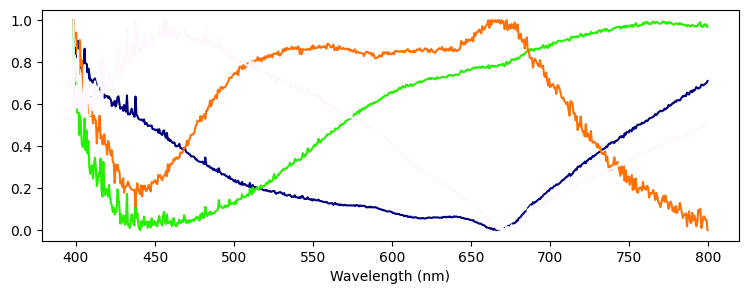

In [46]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

normalize_nmf_features = True

cmap = colormaps['gist_ncar']

inner_dim = W.shape[1]

fig, axs = plt.subplots(figsize=(9, 3))
for i in range(inner_dim):
    comp = W[:, i]
    if normalize_nmf_features:
        comp = 1 - (comp / comp.max())
    axs.plot(bands[~mask_non_informative_channel], comp, c=cmap(i / (inner_dim - 1)))
axs.set_xlabel('Wavelength (nm)')

## convert to basis functions
express cluster centers in terms of a set of basis functions (b-splines) to reduce dimensionality and then perform decomposition

### fit bsplines to cluster centers

In [47]:
from scipy.interpolate import make_lsq_spline, BSpline

# find knots
DEGREE = 3
# knots = [490, 580,  670, 800, 900]
knots = np.arange(400, 1000 + 50, 50)
# knots_padded = pad_knots_by_deg(knots, DEGREE)
knots_padded = np.r_[(bands[0],) * (DEGREE + 1),
knots,
                     (bands[-1],) * (DEGREE + 1)]

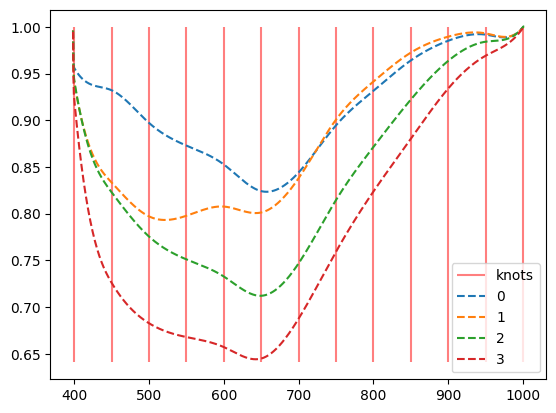

In [48]:
spl_coeffs = []

plt.vlines(knots, centers_kmeans.min(), centers_kmeans.max(), colors='r', label='knots', alpha=.5)
for i in range(centers_kmeans.shape[0]):
    y = centers_kmeans[i, :]
    spl = make_lsq_spline(bands, y, t=knots_padded, k=DEGREE)
    # plt.plot(bands, y, c=f'C{i}')
    plt.plot(bands, spl(bands), c=f'C{i}', linestyle='--', label=i)
    spl_coeffs.append(spl.c)
plt.legend()
spl_coeffs = np.array(spl_coeffs)

In [49]:
spl_coeffs

array([[0.99643954, 0.95744085, 0.93246881, 0.94335172, 0.89193175,
        0.87181357, 0.85794258, 0.81209575, 0.83812425, 0.89960657,
        0.9305845 , 0.96662992, 0.98679218, 0.99676374, 0.98285272,
        1.00028252, 0.99998631],
       [0.99617636, 0.94585343, 0.86184327, 0.83421862, 0.78803655,
        0.79582921, 0.81488579, 0.78997249, 0.83248456, 0.90746654,
        0.94132761, 0.9755124 , 0.99088778, 0.99776499, 0.98309675,
        1.00004102, 1.00002553],
       [0.99584411, 0.94848067, 0.85958494, 0.822488  , 0.77011931,
        0.74977264, 0.7369208 , 0.69864912, 0.74075363, 0.81874397,
        0.87146618, 0.92350422, 0.96707426, 0.98954936, 0.98249389,
        1.00075448, 0.99991972],
       [0.99471265, 0.93198118, 0.78155096, 0.71626946, 0.67816283,
        0.66691691, 0.66115399, 0.63120892, 0.68300346, 0.76183872,
        0.82516576, 0.87932003, 0.93772001, 0.97349947, 0.97960308,
        0.99990808, 0.99997244]])

In [50]:
print(spl_coeffs.min(), spl_coeffs.max(), spl_coeffs.shape)
print('spl_coeffs contains the coefficients for (n_clusters x n_basis_functions) ~ (n_samples x n_features)')

0.6312089164762246 1.0007544812367173 (4, 17)
spl_coeffs contains the coefficients for (n_clusters x n_basis_functions) ~ (n_samples x n_features)


### perform NMF on coefficients 

In [51]:
model = NMF(max_iter=10000, init='nndsvd', n_components=4)
# model = NMF(max_iter=10000, init='random', n_components=4)

spl_coeffs[spl_coeffs > 1] = 1

X = 1 - spl_coeffs

W = model.fit_transform(X)
H = 1 - model.components_

In [52]:
W.shape, H.shape, spl_coeffs.shape

((4, 4), (4, 17), (4, 17))

In [53]:
model.reconstruction_err_

np.float64(9.562112555073514e-05)

Text(0.5, 0, 'cluster index')

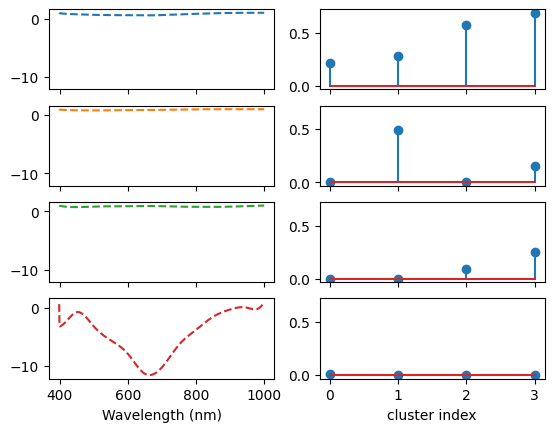

In [54]:
n_inner = W.shape[1]

fig, axs = plt.subplots(ncols=2, nrows=n_inner, sharex='col', sharey='col')

for i in range(n_inner):
    # spl = BSpline(c=spl_coeffs[i, :], t=knots_padded, k=DEGREE)
    spl_nmf = BSpline(c=H[i, :], t=knots_padded, k=DEGREE)
    # plt.plot(bands, spl(bands), c=f'C{i}')
    axs[i, 0].plot(bands, spl_nmf(bands), c=f'C{i}', linestyle='--')
    axs[i, 1].stem(W[:, i])
axs[-1, 0].set_xlabel('Wavelength (nm)')
axs[-1, 1].set_xlabel('cluster index')

In [55]:
H

array([[  0.99417132,   0.92669666,   0.80212102,   0.73675403,
          0.6332397 ,   0.59918828,   0.58286699,   0.52124182,
          0.59344311,   0.73551137,   0.82137981,   0.91228377,
          0.97512753,   1.        ,   0.97483133,   1.        ,
          0.99993011],
       [  0.99550246,   0.93102419,   0.8302125 ,   0.81103017,
          0.77566089,   0.81111392,   0.85949585,   0.84372574,
          0.88949691,   0.96180235,   0.98202826,   1.        ,
          0.99556758,   0.99540886,   0.97979274,   0.99999276,
          1.        ],
       [  0.99762018,   0.97168963,   0.77171825,   0.70104605,
          0.85747608,   0.88455142,   0.87626964,   0.93657786,
          0.91664374,   0.79481943,   0.79965342,   0.7545485 ,
          0.81918828,   0.89529468,   1.        ,   0.99967639,
          1.        ],
       [  0.63600072,  -3.22474611,  -2.93229199,   1.        ,
         -3.60954021,  -5.64236817,  -7.29135847, -12.44204572,
        -10.78447464,  -5.89808029,

### transform entire dataset

In [94]:
imcube_for_final = np.asarray(imcube, dtype=float)
if normalize:
    imcube_for_final = remove_continuum(imcube_for_final, bands=bands)

KeyboardInterrupt: 

In [54]:
imcube_for_final[np.isnan(imcube_for_final)] = 1

calcing B-spline coefficients: 100%|██████████| 3529578/3529578 [04:48<00:00, 12227.13it/s]


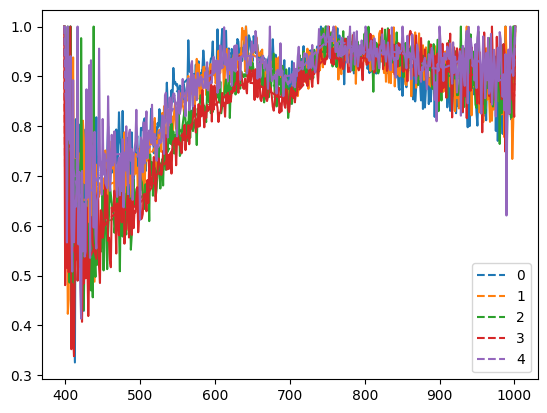

In [81]:
# find b-spline coefficients
spl_coeffs_imcube = []

# ravel image dimension
n_rows, n_cols = imcube_for_final.shape[:2]
n_pixels = n_rows * n_cols

for i1d in tqdm(range(n_pixels), total=n_pixels, desc='calcing B-spline coefficients'):
    i, j = np.unravel_index(i1d, (n_rows, n_cols))
    y = imcube_for_final[i, j, :]
    spl = make_lsq_spline(bands, y, t=knots_padded, k=DEGREE)
    if i1d < 5:
        plt.plot(bands, y, c=f'C{i1d}')
        plt.plot(bands, spl(bands), c=f'C{i1d}', linestyle='--', label=i1d)
    spl_coeffs_imcube.append(spl.c)
plt.legend()

spl_coeffs_imcube = np.array(spl_coeffs_imcube)

In [82]:
spl_coeffs_imcube.min(), spl_coeffs_imcube.max(), spl_coeffs_imcube.shape

(np.float64(-0.17112424615453142),
 np.float64(1.1186905029976404),
 (3529578, 17))

In [83]:
# predict using NMF
spl_coeffs_imcube[spl_coeffs_imcube > 1] = 1
spl_coeffs_imcube[spl_coeffs_imcube < 0] = 0
X_imcube = 1 - spl_coeffs_imcube

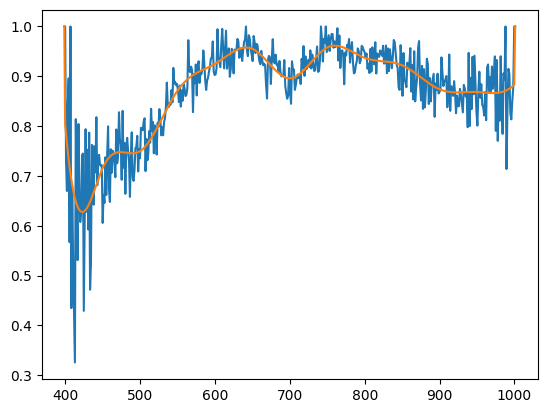

In [88]:
coeffs = spl_coeffs_imcube[0, :]
spl = BSpline(t=knots_padded, c=coeffs, k=DEGREE)
plt.plot(bands, imcube_for_final[0, 0, :])
plt.plot(bands, spl(bands))

In [58]:
np.linalg.pinv(W).shape, X_imcube.shape

((4, 7), (3529578, 17))

In [85]:
# find inverse of W to transform V into H
W_imcube = model.transform(X_imcube)
W_imcube.shape

(3529578, 4)

In [ ]:
# bin row-wise
X_imcube_binned = np.zeros(...)


creating NMF compound plot: 100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


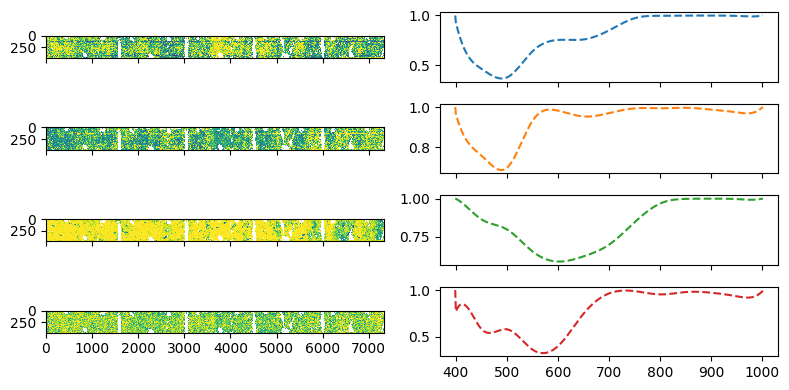

In [117]:
fig, axs = plt.subplots(nrows=W_imcube.shape[-1], ncols=2, sharey=False, sharex='col', layout='tight', figsize=(8, 4))
for feature in tqdm(range(W_imcube.shape[-1]), desc='creating NMF compound plot'):
    img_ = np.zeros((n_rows, n_cols), dtype=float)
    for i1d in range(n_pixels):  # use same function to select indices as for creation of X_imcube
        i, j = np.unravel_index(i1d, (n_rows, n_cols))
        img_[i, j] = W_imcube[i1d, feature]

    mask__ = mask > 0
    vals = img_[~mask__]

    # lower = np.nanquantile(img_, .05)
    # upper = np.nanquantile(img_, .95)
    # vals = np.clip(vals, lower, upper)
    vals = vals - np.nanmin(vals)
    vals = vals / np.nanmax(vals)
    vals = 1 - vals

    img_[~mask__] = vals
    img_[mask__] = np.nan  # ensure mask is NaN

    axs[feature, 0].imshow(img_.T, interpolation='none')
    spl_nmf = BSpline(c=H[feature, :], t=knots_padded, k=DEGREE)
    axs[feature, 1].plot(bands, spl_nmf(bands), c=f'C{feature}', linestyle='--')
# plt.show()
plt.savefig('temp.pdf')

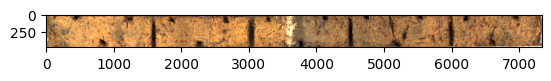

In [124]:
plt.imshow(np.moveaxis(rgb_img, 0, 1))
plt.savefig('temp.pdf')

## perform dictionary learning

In [ ]:
from sklearn.decomposition import DictionaryLearning, FactorAnalysis, FastICA, KernelPCA, PCA, TruncatedSVD

model = PCA(n_components=5)

X_dl = 1 - centers_kmeans
X_dl[X_dl < .1] = 0

V = model.fit_transform(X_dl)

In [ ]:
print(f'data has shape {X_dl.shape} (n_samples, n_features)')

In [ ]:
model.error_

In [ ]:
model.components_

In [ ]:
for i in range(model.components_.shape[0]):
    plt.plot(bands, 1 - model.components_[i, :])